In [1]:
import os
import sys
import subprocess
import numpy as np
np.set_printoptions(precision=4, suppress=True)

import cortex
from cortex.polyutils import voxelize

from scipy.ndimage.morphology import binary_erosion

from nibabel.nifti1 import Nifti1Image
from nibabel import save as nbsave, load as nbload

import matplotlib
matplotlib.use('Agg')

# from matplotlib import pyplot as plt
# %matplotlib inline
# plt.style.use('ggplot')

# import realtimefmri
# from realtimefmri.core.utils import generate_command

# Transform white matter surface points to anatomical space

In [3]:
# subject = 'ANfs'
# xfmname = '20150722AN_auto_reading'

# subject = 'SSfs_auto2'
# xfmname = '20160128_wm_detrend'

# subject = 'MLfs'
# xfmname = 'MLfs_nb'
subject = 'TZfs2'
xfmname = 'controller_test_20161026TZ2'

In [3]:
anat = cortex.db.get_anat(subject)

In [4]:
wm_surf_pts, wm_surf_polys = cortex.db.get_surf(subject=subject,
                                                type='wm',
                                                hemisphere='both',
                                                merge=True)

anat_nifti1 = cortex.db.get_anat(subject)
anat_affine = anat_nifti1.affine
wm_surf_pts_anat = np.linalg.inv(anat_affine).dot(np.r_[wm_surf_pts.T, np.ones((1,wm_surf_pts.shape[0]))]).T[:,:3]

In [5]:
wm_mask_anatref = voxelize(wm_surf_pts_anat,
                       wm_surf_polys,
                       shape=(256,256,256),
                       center=(0,0,0),
                       mp=False)

if not os.path.exists('../database/'+subject):
    os.mkdir('../database/'+subject)
    
nbsave(Nifti1Image(wm_mask_anatref, anat_affine), '../database/'+subject+'/wm_mask_anatref.nii')

SystemExit: Unable to access the X Display, is $DISPLAY set properly?

To exit: use 'exit', 'quit', or Ctrl-D.


### Load white matter voxels

In [13]:
wm_mask_anatref = nbload('../database/'+subject+'/wm_mask_anatref.nii')

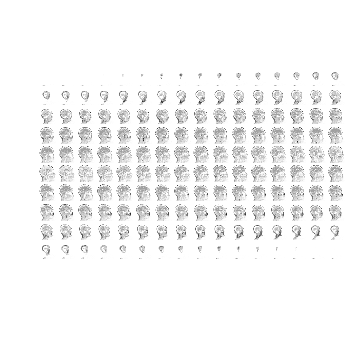

In [21]:
cortex.mosaic(anat_nifti1.get_data().astype(float));

# White matter mask in functional reference space
anat2epispace does it all, as long as you use it correctly (transform data in and out)

In [22]:
wm_mask_funcref = cortex.volume.anat2epispace(wm_mask_anatref.get_data().T, subject, xfmname).T
wm_mask_funcref = binary_erosion(wm_mask_funcref)

In [4]:
funcref_nifti1 = cortex.db.get_xfm(subject, xfmname).reference

In [23]:
wm_mask_funcref = Nifti1Image(wm_mask_funcref.astype(float), funcref_nifti1.affine)

In [5]:
funcref_nifti1.affine

array([[  -2.24  ,    0.    ,    0.    ,  112.    ],
       [   0.    ,   -2.24  ,    0.    ,  123.1864],
       [   0.    ,    0.    ,    4.13  ,  -74.2676],
       [   0.    ,    0.    ,    0.    ,    1.    ]])

In [8]:
nbsave(funcref_nifti1, '../database/'+subject+'/funcref.nii')

In [26]:
nbsave(wm_mask_funcref, '../database/'+subject+'/wm_mask_funcref.nii')

# Visual check of white matter mask on functional reference image

In [27]:
from realtimefmri.core.utils import generate_command

In [28]:
fsl_args = [
    {
        'position': 'last',
        'value': funcref_nifti1.get_filename()
    },
    {
        'position': 'last',
        'value': '../database/'+subject+'/wm_mask_funcref.nii'
    }
]
cmd = generate_command('fslview', fsl_args)
print ' '.join(cmd)
subprocess.call(cmd)

fslview ../database/BGfs/funcref.nii ../database/BGfs/wm_mask_funcref.nii


0

# Gray matter mask in functional reference space
It already is, just save voxeldata with functional reference affine in a Nifti1 file

In [6]:
gm_mask_pycortex = cortex.db.get_mask(subject, xfmname, type='thick')
gm_mask_funcref = Nifti1Image(gm_mask_pycortex.T.astype(float), funcref_nifti1.affine)

In [7]:
gm_mask_pycortex.sum()

84489

In [8]:
ls ../database/TZfs2/

funcref.nii  gm_mask_funcref.nii


In [9]:
!pwd

/home/jlg/robertg/code/realtimefmri/notebook


In [10]:
nbsave(gm_mask_funcref, '/auto/k1/robertg/code/realtimefmri/database/'+subject+'/gm_mask_funcref.nii')

In [13]:
print funcref_nifti1.shape
print gm_mask_funcref.shape
print wm_mask_funcref.shape

(100, 100, 30)
(100, 100, 30)


NameError: name 'wm_mask_funcref' is not defined

In [33]:
fsl_args = [
    {
        'position': 'last',
        'value': '../database/'+subject+'/gm_mask_funcref.nii'
    },
    {
        'position': 'last',
        'value': '../database/'+subject+'/wm_mask_funcref.nii'
    },
    {
        'position': 'last',
        'value': '../database/'+subject+'/funcref.nii'
    }
]
cmd = generate_command('fslview', fsl_args)
print ' '.join(cmd)
subprocess.call(cmd)

fslview ../database/BGfs/gm_mask_funcref.nii ../database/BGfs/wm_mask_funcref.nii ../database/BGfs/funcref.nii


0

## Get activations

In [34]:
from realtimefmri.core.preprocessing import RawToNifti, MotionCorrect, ApplyMask, WMDetrend

In [48]:
mc = MotionCorrect(subject, reference_name='funcref.nii')
apply_gm_mask = ApplyMask(subject=subject, mask_name='gm_mask_funcref')
apply_wm_mask = ApplyMask(subject=subject, mask_name='wm_mask_funcref')
wm = WMDetrend(subject, None)

In [49]:
from glob import glob

training_data_paths = glob('../database/'+subject+'/wmd_train/*.nii')
training_data_path = training_data_paths[0]
training_data = nbload(training_data_path)
training_data.get_data().shape # xyz n

(100, 100, 30, 450)

In [50]:
ntrials = training_data.shape[-1]
n_gm = int(gm_mask_funcref.get_data().sum())
n_wm = int(wm_mask_funcref.get_data().sum())

gm_activity = np.empty((ntrials, n_gm))
wm_activity = np.empty((ntrials, n_wm))

print gm_activity.shape
print wm_activity.shape

(450, 87852)
(450, 13582)


In [52]:
i = 0
print ntrials,
for i in range(ntrials):
    print i,
    volume = training_data.get_data()[...,i]
    volume = Nifti1Image(volume, training_data.affine)
    volume_mc = mc.run(volume)
    gm_activity[i,:] = apply_gm_mask.run(volume_mc)
    wm_activity[i,:] = apply_wm_mask.run(volume_mc)
    i += 1

450 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 27

In [53]:
model, pca = wm.train(gm_activity, wm_activity)

In [54]:
import cPickle
import time

current_time = time.strftime('%Y%m%d_%H%M')
model_fpath = 'model-%s.pkl'%current_time
print model_fpath

with open(os.path.join('../database/'+subject+'/', model_fpath), 'w') as f:
    cPickle.dump(model, f)

pca_fpath = 'pca-%s.pkl'%current_time
print pca_fpath

with open(os.path.join('../database/'+subject+'/',
                       pca_fpath), 'w') as f:
    cPickle.dump(pca, f)

model-20160128_1547.pkl
pca-20160128_1547.pkl


In [55]:
ls ../database/SSfs_auto2/

funcref.nii          gm_mask_left.nii   model-20160128_1547.pkl  wmd_train/           wm_mask_funcref.nii
gm_mask_funcref.nii  gm_mask_right.nii  pca-20160128_1547.pkl    wm_mask_anatref.nii


In [37]:
cortex.webshow(cortex.Volume(np.transpose(training_data.get_data(), (3,2,1,0)), subject, xfmname))

Started server on port 35799
['rois']


<JS: window.viewers>

# Make a new reference image
If no reference image exists for the training data, make a new transform, along with surfaces

In [103]:
new_xfmname = time.strftime('%Y%m%d_wm_detrend')

new_reference = training_data.get_data()[...,0]
nbsave(Nifti1Image(new_reference, training_data.affine), 'new_reference.nii')

In [108]:
cortex.align.automatic(subject, new_xfmname, 'new_reference.nii')

Generating brainmask anatomical...
Brain masking anatomical...
Generating whitematter anatomical...
Segmenting the brain...
FLIRT pre-alignment
Running BBR
Success


In [16]:
volume.shape

(100, 100, 30)

In [25]:
hasattr([1,2,3], '__len__')

True

In [24]:
x = [1,3,2]

In [ ]:
x.__